# Define Functions
This section defines the functions used for calculating portfolio volatility, expected return, 
goal achievement probability, and the objective (failure probability) to minimize.

In [17]:
import numpy as np
from scipy.stats import norm

def sd_f(weight_vector, covar_table):
    covar_vector = np.zeros(len(weight_vector))
    for z in range(len(weight_vector)):
        covar_vector[z] = np.sum(weight_vector * covar_table[:, z])
    return np.sqrt(np.sum(weight_vector * covar_vector))

In [18]:
def mean_f(weight_vector, return_vector):
    return np.sum(weight_vector * return_vector)

In [19]:
def phi_f(goal_vector, goal_allocation, pool, mean, sd):
    # goal_vector is [value ratio, funding requirement, time horizon]
    required_return = (goal_vector[1] / (pool * goal_allocation))**(1 / goal_vector[2]) - 1
    if goal_allocation * pool >= goal_vector[1]:
        return 1
    else:
        return 1 - norm.cdf(required_return, loc=mean, scale=sd)

In [20]:
def optim_function(weights):
    # Uses the current global variables: goal_vector, allocation, pool, return_vector, covar_table
    return 1 - phi_f(
        goal_vector,
        allocation,
        pool,
        mean_f(weights, return_vector),
        sd_f(weights, covar_table)
    )

In [21]:
def constraint_function(weights):
    # For SciPy equality constraints, we require constraint_function(weights) == 0.
    return np.sum(weights) - 1

In [22]:
def mvu_f(weights):
    # mvu_f is defined for mean-variance optimization (not used below).
    return -(mean_f(weights, return_vector) - 0.5 * gamma * sd_f(weights, covariances)**2)

In [23]:
def r_req_f(goal_vector, goal_allocation, pool):
    return (goal_vector[1] / (goal_allocation * pool))**(1 / goal_vector[2]) - 1

# Load & Parse Data

In [24]:
import pandas as pd

# Set number of Monte Carlo trials (matching R's 10^5)
n_trials = 10**5

# Load data from CSV files (adjust the paths as needed)
goal_data_raw = pd.read_csv(r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/AEF_msc_thesis_GBI/Franklin/Goals-Based Utility Practitioners Guide/Example Goal Details.csv")
#goal_data_raw = pd.read_csv(r"C:\Users\admin\Desktop\Thesis\AEF_msc_thesis_GBI\Example Goal Details.csv")
capital_market_expectations_raw = pd.read_csv(r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/AEF_msc_thesis_GBI/Franklin/Goals-Based Utility Practitioners Guide/Capital Market Expectations.csv")
#capital_market_expectations_raw = pd.read_csv(r"C:\Users\admin\Desktop\Thesis\AEF_msc_thesis_GBI\Capital Market Expectations.csv")
correlations_raw = pd.read_csv(r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/AEF_msc_thesis_GBI/Franklin/Goals-Based Utility Practitioners Guide/Correlations - Kitchen Sink.csv")
#correlations_raw = pd.read_csv(r"C:\Users\admin\Desktop\Thesis\AEF_msc_thesis_GBI\Correlations - Kitchen Sink.csv")

# Record number of potential investments and goals
num_assets = len(capital_market_expectations_raw.iloc[:, 1])
num_goals = goal_data_raw.shape[1] - 1

# Create vector of expected returns
return_vector = capital_market_expectations_raw.iloc[:, 1].to_numpy()

# Get the correlations as a numeric DataFrame
correlations = correlations_raw.iloc[:15, 1:16].astype(float)

# Build the covariance matrix
covariances = np.zeros((num_assets, num_assets))
for i in range(num_assets):
    for j in range(num_assets):
        covariances[j, i] = (
            capital_market_expectations_raw.iloc[i, 2] *
            capital_market_expectations_raw.iloc[j, 2] *
            correlations.iloc[j, i]
        )

# Parse Goal Data
Each goal vector is of the form: [value ratio, funding requirement, time horizon]

In [25]:
goal_A = [
    goal_data_raw.iloc[0, 1],
    goal_data_raw.iloc[1, 1],
    goal_data_raw.iloc[2, 1]
]
goal_B = [
    goal_data_raw.iloc[0, 2],
    goal_data_raw.iloc[1, 2],
    goal_data_raw.iloc[2, 2]
]
goal_C = [
    goal_data_raw.iloc[0, 3],
    goal_data_raw.iloc[1, 3],
    goal_data_raw.iloc[2, 3]
]
goal_D = [
    goal_data_raw.iloc[0, 4],
    goal_data_raw.iloc[1, 4],
    goal_data_raw.iloc[2, 4]
]

# Total pool of wealth
pool = 4654000

# Step 1: Optimal Within-Goal Allocation
Enumerate possible across-goal allocations (from 0.01 to 1)
and, for each goal, optimize the subportfolio weights.

In [26]:
from scipy.optimize import minimize

goal_allocation = np.arange(0.01, 1.01, 0.01)

# Starting weights (random initialization normalized to sum to 1)
starting_weights = np.random.uniform(0, 1, num_assets)
starting_weights /= np.sum(starting_weights)

# Initialize matrices to store the optimal weights for each goal
optimal_weights_A = np.zeros((len(goal_allocation), num_assets))
optimal_weights_B = np.zeros((len(goal_allocation), num_assets))
optimal_weights_C = np.zeros((len(goal_allocation), num_assets))
optimal_weights_D = np.zeros((len(goal_allocation), num_assets))

In [27]:
# Optimization loop for each allocation level
for i, alloc in enumerate(goal_allocation):
    allocation = alloc      # Global variable used in optim_function
    covar_table = covariances
    
    # Goal A Optimization
    goal_vector = goal_A   # Global variable used in optim_function
    if goal_A[1] <= pool * allocation:
        optimal_weights_A[i, :] = [0]*(num_assets - 1) + [1]
    else:
        result = minimize(
            optim_function,
            starting_weights,
            constraints=[{'type': 'eq', 'fun': constraint_function}],
            bounds=[(0, 1)] * num_assets,
            method='SLSQP'
        )
        optimal_weights_A[i, :] = result.x

    # Goal B Optimization
    goal_vector = goal_B
    if goal_B[1] <= pool * allocation:
        optimal_weights_B[i, :] = [0]*(num_assets - 1) + [1]
    else:
        result = minimize(
            optim_function,
            starting_weights,
            constraints=[{'type': 'eq', 'fun': constraint_function}],
            bounds=[(0, 1)] * num_assets,
            method='SLSQP'
        )
        optimal_weights_B[i, :] = result.x

    # Goal C Optimization
    goal_vector = goal_C
    if goal_C[1] <= pool * allocation:
        optimal_weights_C[i, :] = [0]*(num_assets - 1) + [1]
    else:
        result = minimize(
            optim_function,
            starting_weights,
            constraints=[{'type': 'eq', 'fun': constraint_function}],
            bounds=[(0, 1)] * num_assets,
            method='SLSQP'
        )
        optimal_weights_C[i, :] = result.x

    # Goal D Optimization
    goal_vector = goal_D
    if goal_D[1] <= pool * allocation:
        optimal_weights_D[i, :] = [0]*(num_assets - 1) + [1]
    else:
        result = minimize(
            optim_function,
            starting_weights,
            constraints=[{'type': 'eq', 'fun': constraint_function}],
            bounds=[(0, 1)] * num_assets,
            method='SLSQP'
        )
        optimal_weights_D[i, :] = result.x

In [28]:
# Calculate the best probability (phi) for each allocation level for every goal
phi_A = np.zeros(len(goal_allocation))
phi_B = np.zeros(len(goal_allocation))
phi_C = np.zeros(len(goal_allocation))
phi_D = np.zeros(len(goal_allocation))

for i, alloc in enumerate(goal_allocation):
    phi_A[i] = phi_f(goal_A, alloc, pool,
                     mean_f(optimal_weights_A[i, :], return_vector),
                     sd_f(optimal_weights_A[i, :], covariances))
    phi_B[i] = phi_f(goal_B, alloc, pool,
                     mean_f(optimal_weights_B[i, :], return_vector),
                     sd_f(optimal_weights_B[i, :], covariances))
    phi_C[i] = phi_f(goal_C, alloc, pool,
                     mean_f(optimal_weights_C[i, :], return_vector),
                     sd_f(optimal_weights_C[i, :], covariances))
    phi_D[i] = phi_f(goal_D, alloc, pool,
                     mean_f(optimal_weights_D[i, :], return_vector),
                     sd_f(optimal_weights_D[i, :], covariances))

# Step 2: Optimal Across-Goal Allocation
Simulate goal weights and compute utility for each trial.

In [29]:
# Simulate goal weights: each row is a simulated allocation (in percentages)
sim_goal_weights = np.zeros((n_trials, num_goals))
for i in range(n_trials):
    rand_vector = np.random.uniform(0, 1, num_goals)
    normalizer = np.sum(rand_vector)
    # Round percentages and ensure a minimum of 1
    sim_goal_weights[i, :] = np.where(
        np.round((rand_vector / normalizer) * 100, 0) < 1,
        1,
        np.round((rand_vector / normalizer) * 100)
    )
sim_goal_weights = sim_goal_weights.astype(int)

# Calculate utility for each simulated portfolio.
# Note: subtract 1 from simulated weights for 0-indexing.
utility = (
    goal_A[0] * phi_A[sim_goal_weights[:, 0] - 1] +
    goal_A[0] * goal_B[0] * phi_B[sim_goal_weights[:, 1] - 1] +
    goal_A[0] * goal_B[0] * goal_C[0] * phi_C[sim_goal_weights[:, 2] - 1] +
    goal_A[0] * goal_B[0] * goal_C[0] * goal_D[0] * phi_D[sim_goal_weights[:, 3] - 1]
)

# Find the index of the portfolio with the highest utility
index = np.argmax(utility)
optimal_goal_weights = sim_goal_weights[index, :]

# Step 3: Optimal Subportfolios & Aggregate Portfolio
Retrieve the optimal subportfolio allocations and compute the aggregate portfolio.

In [30]:
# Retrieve optimal subportfolio allocations
optimal_subportfolios = np.zeros((num_goals, num_assets))
goals = ["A", "B", "C", "D"]

# For each goal, use the simulated percentage to select the corresponding row 
# from the optimal weights matrix (adjust for zero-indexing)
for i in range(num_goals):
    optimal_subportfolios[i, :] = eval(f"optimal_weights_{goals[i]}")[optimal_goal_weights[i] - 1, :]

# Compute the optimal aggregate investment portfolio.
# Normalize the simulated goal weights so they sum to 1, then compute the dot product.
optimal_goal_weights_norm = optimal_goal_weights / np.sum(optimal_goal_weights)
optimal_aggregate_portfolio = optimal_goal_weights_norm @ optimal_subportfolios

# Visualize Results
Plot the Goal A subportfolio allocation as a function of the across-goal allocation.

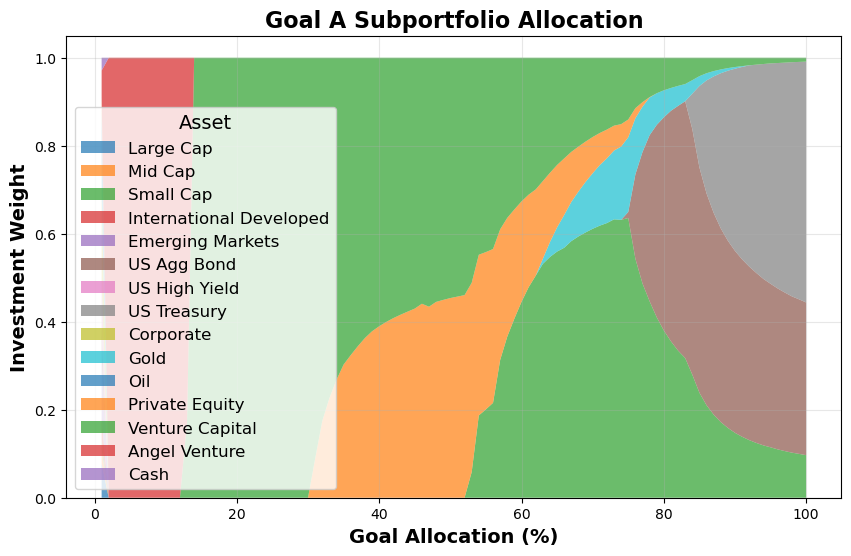

In [31]:
import matplotlib.pyplot as plt

# Asset names from the first column of the capital market expectations
asset_names = capital_market_expectations_raw.iloc[:, 0].astype(str).tolist()

# Use stackplot to display the Goal A subportfolio allocation (stacked areas) versus goal allocation (in %)
plt.figure(figsize=(10, 6))
plt.stackplot(goal_allocation * 100, optimal_weights_A.T, labels=asset_names, alpha=0.7)
plt.xlabel("Goal Allocation (%)", fontsize=14, fontweight='bold')
plt.ylabel("Investment Weight", fontsize=14, fontweight='bold')
plt.title("Goal A Subportfolio Allocation", fontsize=16, fontweight='bold')
plt.legend(title="Asset", fontsize=12, title_fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Print Results

In [32]:
print("Optimal Across-Goal Allocation:")
print(optimal_goal_weights)

print("\nOptimal Aggregate Investment Allocation:")
print(optimal_aggregate_portfolio)

Optimal Across-Goal Allocation:
[77  8 15  1]

Optimal Aggregate Investment Allocation:
[4.72039473e-06 3.01360384e-16 3.71569589e-01 7.94781702e-06
 7.03540015e-06 2.27848689e-01 9.84664825e-06 6.68658923e-05
 1.34727930e-06 7.86247607e-02 2.23339048e-05 4.24520001e-02
 1.21592381e-01 9.90398811e-03 1.47888495e-01]
